<a href="https://colab.research.google.com/github/godfather-is-me/MNIST-DigitRecogniser/blob/main/MNIST_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Reads

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import pickle
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split

In [2]:
# Load data
train, test = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
train[0].shape

(60000, 28, 28)

In [10]:
## Do not run
# -- From previously loaded csv files

# Train and test values
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


## Visualize the data

In [7]:
def visual_random(Xdata, Ydata):
  # Assuming input is numpy array shaped (x, 28 , 28)
  index = np.random.randint(0, 42000)
  img = Xdata[index]
  label = Ydata[index]

  plt.imshow(img, cmap='gray')
  plt.title(label)
  plt.axis('off')

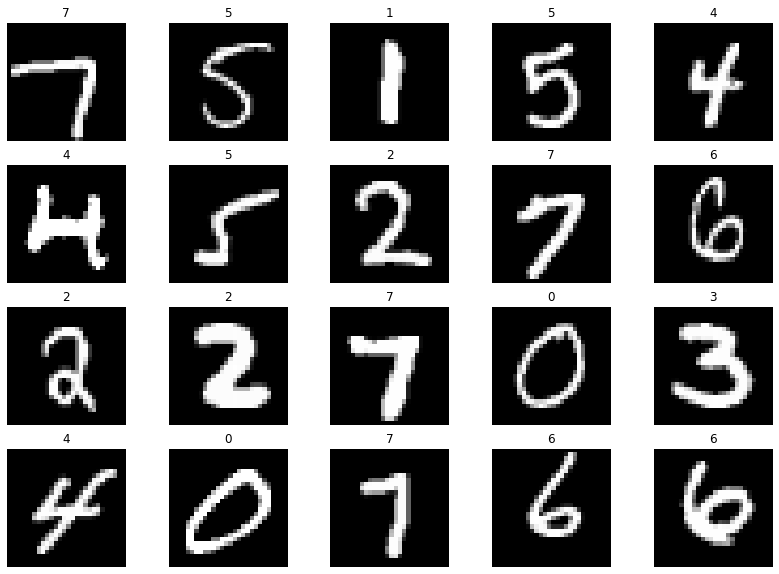

In [8]:
plt.figure(figsize=(14, 10))
for i in range(20):
  ax = plt.subplot(4, 5, i + 1)
  visual_random(train[0], train[1])

## Implementing morphological methods on data

### Train/test split

In [22]:
## Do not run 
# --- Required for dataframe

X = train.drop('label', axis = 1).values
y = train['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train[0], train[1], test_size=0.2)

### Creating a pipeline on a subset of the data

1. Original image
2. Upscaled image (x4)
3. Binarise image
4. Closing of the image
5. Downscaling the image

In [12]:
pipe_subset = X_train.astype('uint8')[:7].copy()

## Kernel for closing
kernel = np.ones(shape=(7,7), dtype=np.uint8)

## Resize dimensions
original = 28
width = original * 4
height = original * 4

for i, img in enumerate(pipe_subset):
  img = ((cv2.resize(img, (height, width)) > 127) * 255).astype('uint8')
  img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1).astype('uint8')
  img = cv2.resize(img, (original, original))
  pipe_subset = np.concatenate((pipe_subset, np.expand_dims(img, axis=0)), axis=0)


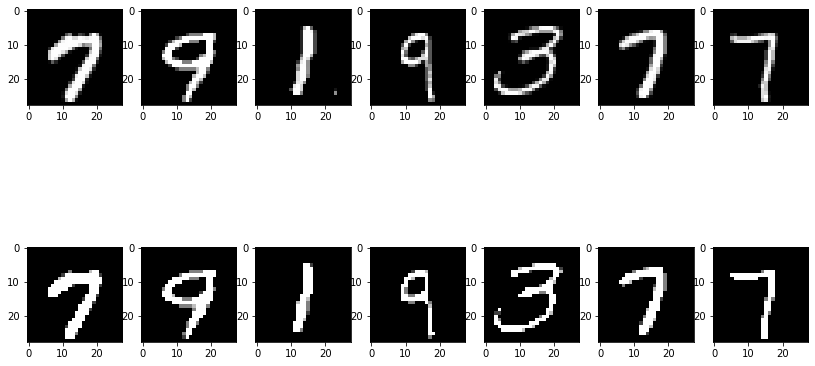

In [13]:
plt.figure(figsize=(14, 8))
for i in range(len(pipe_subset)):
  plt.subplot(2, 7, i + 1)
  # plt.title()
  plt.imshow(pipe_subset[i], cmap='gray')

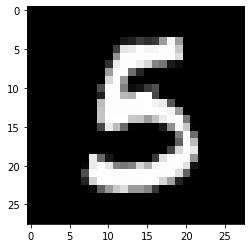

In [28]:
plt.imshow(X_train[0], cmap='gray')

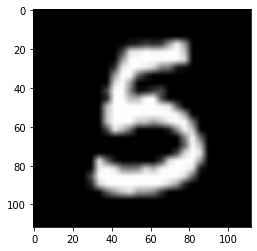

In [29]:
plt.imshow(cv2.resize(X_train[0].astype('uint8'), (112, 112)), cmap='gray')

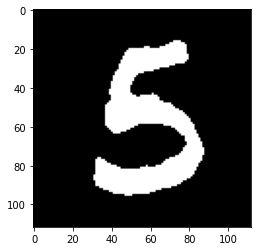

In [35]:
upscale_test = (cv2.resize(X_train[0].astype('uint8'), (112, 112)) > 127) * 255
plt.imshow(upscale_test, cmap='gray')

In [37]:
upscale_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
kernel_test = np.ones(shape=(7,7), dtype=np.uint8)
close_upscale_test = cv2.morphologyEx(upscale_test.astype('uint8'), cv2.MORPH_CLOSE, kernel_test, iterations=1)

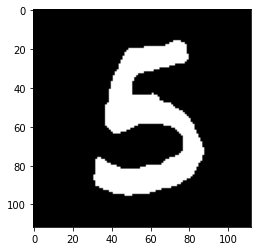

In [40]:
plt.imshow(close_upscale_test, cmap='gray')

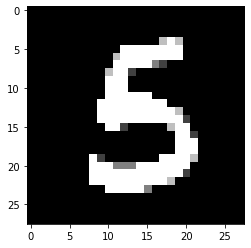

In [41]:
plt.imshow(cv2.resize(close_upscale_test.astype('uint8'), (28, 28)), cmap='gray')

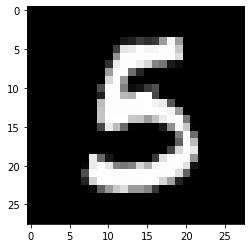

In [42]:
plt.imshow(X_train[0], cmap='gray')

### Pipeline

In [14]:
def pipeline(data):
  data = data.astype('uint8')
  
  ## Kernel for closing
  kernel = np.ones(shape=(7,7), dtype=np.uint8)

  ## Resize dimensions
  original = 28
  width = original * 4
  height = original * 4

  return_data = np.zeros((1, original, original))

  for img in data:
    img = ((cv2.resize(img, (height, width)) > 127) * 255).astype('uint8')
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1).astype('uint8')
    img = cv2.resize(img, (original, original))
    # pipe_subset = np.concatenate((pipe_subset, np.expand_dims(img, axis=0)), axis=0)
    
    # Data not expanded by dimensoion
    # Same y_train to be used as original
    return_data = np.concatenate((return_data, np.expand_dims(img, axis=0)), axis=0)

  return return_data[1:]

In [15]:
X_train_pipelined = pipeline(X_train)

In [16]:
X_train.shape

(48000, 28, 28)

In [17]:
X_train_pipelined.shape

(48000, 28, 28)

In [66]:
X_train_pipelined

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
## Do not run

np.save('X_train_pipelined.npy', X_train_pipelined)

In [92]:
## Do not run

abc = np.load('X_train_pipelined.npy')
abc

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [94]:
## Do not run

(X_train_pipelined == abc).all()

True

## Build model

### Model with non-engineered data

In [34]:
model = keras.Sequential()

model.add(Conv2D(128, (4, 4), input_shape=(28, 28, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.15))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

In [35]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 28, 28, 128)       2176      
                                                                 
 batch_normalization_16 (Bat  (None, 28, 28, 128)      512       
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 28, 28, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 64)        204864    
                                                                 
 batch_normalization_17 (Bat  (None, 24, 24, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)      

In [36]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
    )

In [37]:
history = model.fit(X_train, y_train, epochs=7)

Epoch 1/7
1500/1500 [==============================] - 973s 648ms/step - loss: 0.1543 - accuracy: 0.9573
Epoch 2/7
1500/1500 [==============================] - 966s 644ms/step - loss: 0.0696 - accuracy: 0.9811
Epoch 3/7
1500/1500 [==============================] - 966s 644ms/step - loss: 0.0594 - accuracy: 0.9836
Epoch 4/7
1500/1500 [==============================] - 965s 643ms/step - loss: 0.0441 - accuracy: 0.9875
Epoch 5/7
1500/1500 [==============================] - 950s 633ms/step - loss: 0.0383 - accuracy: 0.9892
Epoch 6/7
1500/1500 [==============================] - 952s 635ms/step - loss: 0.0334 - accuracy: 0.9903
Epoch 7/7
1500/1500 [==============================] - 958s 639ms/step - loss: 0.0313 - accuracy: 0.9914


Text(0.5, 0, 'epochs')

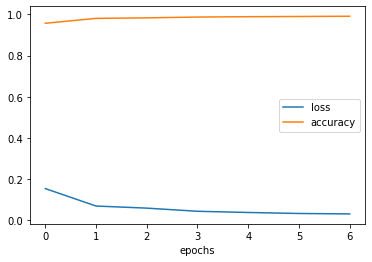

In [38]:
pd.DataFrame(history.history).plot()
plt.xlabel('epochs')

In [40]:
# To pipeline the validation set

y_pred = model.predict(X_test, verbose=1)

375/375 [==============================] - 53s 142ms/step


In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [48]:
y_pred_argmax = np.argmax(y_pred, axis=1)

print(accuracy_score(y_pred_argmax, y_test))
print(classification_report(y_pred_argmax, y_test))
confusion_matrix(y_pred_argmax, y_test)

0.9916666666666667
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1213
           1       1.00      0.99      0.99      1361
           2       0.99      1.00      0.99      1122
           3       0.99      0.99      0.99      1219
           4       0.99      0.99      0.99      1205
           5       0.99      0.99      0.99      1126
           6       0.99      1.00      0.99      1199
           7       1.00      0.99      0.99      1288
           8       0.99      0.99      0.99      1086
           9       0.98      0.99      0.99      1181

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



array([[1195,    0,    0,    1,    0,    3,    8,    0,    2,    4],
       [   0, 1349,    4,    2,    0,    4,    1,    1,    0,    0],
       [   0,    0, 1117,    2,    1,    0,    0,    1,    1,    0],
       [   0,    0,    4, 1208,    0,    2,    1,    0,    3,    1],
       [   1,    1,    0,    0, 1192,    0,    2,    3,    0,    6],
       [   0,    0,    0,    4,    0, 1117,    4,    0,    1,    0],
       [   1,    1,    0,    0,    0,    0, 1197,    0,    0,    0],
       [   0,    2,    2,    0,    2,    0,    0, 1275,    1,    6],
       [   0,    0,    2,    1,    1,    0,    1,    0, 1080,    1],
       [   0,    1,    0,    0,    5,    3,    0,    0,    2, 1170]])

In [54]:
# Trynig base model with the test file
real_test = pd.read_csv("test.csv")
real_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
X_train.shape

(48000, 28, 28)

In [51]:
sample_sub1 = pd.read_csv("sample_submission.csv")
sample_sub1.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [55]:
# Transform to 28, 28 matrix
real_test_value = real_test.values.reshape(-1, 28, 28)

# Predictions
y_real_test_pred = np.argmax(model.predict(real_test_value, verbose=1), axis=1)

# Sample submission
sample_sub1['Label'] = y_real_test_pred

875/875 [==============================] - 125s 143ms/step


In [57]:
sample_sub1.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [56]:
sample_sub1.to_csv("Submission1.csv", index=False)

### Feature Engineered model

In [52]:
model2 = keras.Sequential()

model2.add(Conv2D(128, (4, 4), input_shape=(28, 28, 1), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(Dropout(0.15))

model2.add(Conv2D(64, (5, 5), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(2, 2))
model2.add(Dropout(0.15))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.15))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.15))

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(10, activation='softmax'))

In [53]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 128)       2176      
                                                                 
 batch_normalization_20 (Bat  (None, 28, 28, 128)      512       
 chNormalization)                                                
                                                                 
 dropout_25 (Dropout)        (None, 28, 28, 128)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 64)        204864    
                                                                 
 batch_normalization_21 (Bat  (None, 24, 24, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)      

In [58]:
model2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
history2 = model2.fit(
    X_train_pipelined,
    y_train,
    epochs=7
)

Epoch 1/7
 267/1500 [====>.........................] - ETA: 12:54 - loss: 0.3748 - accuracy: 0.8943

In [ ]:
pd.DataFrame(history2.history).plot()

In [59]:
## Pipeline X_test to fit the norm
X_test_pipeliend = pipeline(X_test)

In [ ]:
y_pipeline_pred = model2.predict(X_test_pipelined, verbose=1)

In [ ]:
y_pipeline_pred_argmax = np.argmax(y_pipeline_pred, axis=1)

print(accuracy_score(y_pipeline_pred_argmax, y_test))
print(classification_report(y_pipeline_pred_argmax, y_test))
confusion_matrix(y_pipeline_pred_argmax, y_test)

Put original test values into pipeline and do final predictions

In [ ]:
sample_sub2 = pd.read_csv("sample_submission.csv")
sample_sub2.head()

In [ ]:
# Transform to 28, 28 matrix
# real_test_value = real_test.values.reshape(-1, 28, 28)

# Predictions
y_real_test_pred2 = np.argmax(model2.predict(real_test_value, verbose=1), axis=1)

# Sample submission
sample_sub2['Label'] = y_real_test_pred2

In [ ]:
sample_sub2.head()

In [ ]:
sample_sub2.to_csv("Submission2.csv", index=False)